* 6.优化
    * 深度学习优化：
        * 深度学习优化和普通优化的差异
        * 基于梯度的优化方法的挑战
    * 凸优化
        * 凸性
        * 凸函数的性质和 Jensen 不等式
        * 如何优化带有限制条件的函数 
    * 优化算法
        * 牛顿法
        * 共轭梯度法
        * 随机梯度下降法
        * 小批量随机梯度下降法 (SGD)
    * 高阶优化算法
        * momentum
        * AdaGrad       
        * RMSProp
        * AdaDelta
        * Adam

In [7]:
from Utils.utils import *

# 优化
优化是为了在所有模型表示空间中利用参数迭代方法（优化方法）找到损失函数最小的模型表示。

## 深度学习优化：
深度学习模型的优化是为了优化针对深度模型进行的优化，在这一部分我们会主要描述深度学习模型的优化和传统优化的差异，以及基于梯度的优化方法在深度学习优化中遇到的问题。

### 深度学习优化和普通优化的差异
一般的优化我们只需要在已知数据上进行优化，即针对训练集进行优化，但是对于深度学习模型而言，我们需要通过在训练数据上的优化获得在未知数据上的损失函数最小值。而训练损失和测试损失并不一直拥有一致的变化，其中一种可能的变化如下：

![img](Pics/testtrainerror.svg)

为了解决这类问题，我们需要对网络建立训练集，验证集，同时保证训练集和验证集本身能反映真实数据的分布，这样我们就能利用验证集上的表现选取良好的模型，正如之前模型选择中提到的那样。
##基于梯度的优化方法的挑战
除了上述训练误差和测试误差不匹配的问题，我们用基于梯度的方法优化深度学习模型还会遇到以下几点问题

#### 局部最优点

#### 鞍点

#### 梯度消失



首先我们阐述一下基于梯度的算法的普遍形式，这里基于梯度的方法是一种基于线搜索的优化方法。在搜索优化过程中，我们希望能对于每个自变量寻找到一个方向，再乘以一个步长，使得我们在将自变量不断往这个方向前进的过程，能促使目标函数不断减小。而基于梯度的下降算法就认为这个方向是梯度的反方向，即迭代公式如下：
$$
f(x)_{new} = f(x - \eta f^{\prime}(x))
$$

这个结论的正确性是明显的。下面我们用两种不同的方法来证明：

**证明：沿梯度反方向移动自变量可以减小函数值**

1. 图形的方法：
我们的自变量的变化范围都是在其周围的局部极小领域变化的。

我们知道梯度为函数在各个方向的导数，而函数导数大于0代表函数在自变量增加的方向函数值增加，导数小于0则反之；因此某一维度导数大于0时将自变量在减小，某一维度导数小于0时函数增大，就能减小函数值。说明梯度的反方向就是函数值减小的方向。其实，梯度的方向还是函数值下降最快的方向。

2. 基于泰勒展开：
首先，泰勒展开公式如下：
$$
f(x+\epsilon)=f(x)+\epsilon f^{\prime}(x)+\mathcal{O}\left(\epsilon^{2}\right)
$$

对于梯度下降算法，我们沿梯度方向的移动量 $\eta f^{\prime}(x)$，并假设这一个移动量是极小量，因此可以看成是$\epsilon$，并进行泰勒展开：

$$
f\left(x-\eta f^{\prime}(x)\right)=f(x)-\eta f^{\prime 2}(x)+\mathcal{O}\left(\eta^{2} f^{\prime 2}(x)\right)
$$

只要$\eta$较小，我们就能保证（因为左边是右边的高阶无穷小量）：
$$
 \mathcal{O}\left(\eta^{2} f^{\prime 2}(x)\right) \lesssim \eta f^{\prime 2}(x)
$$
从而我们就证明了
$$
f\left(x-\eta f^{\prime}(x)\right) \lesssim f(x)
$$


$$
x \leftarrow x-\eta f^{\prime}(x)
$$
那么，这样说来，是不是基于梯度下降的方法就能万无一失地最快地找到最小点了呢，其实并不，因为梯度方向是函数下降最快地方向是针对$x$的一个局部极小领域来说的，因此我们不能保证乘以一个步长之后会到什么位置，同时我们也不能看到局部极小领域之外的范围函数值是如何变化来决定我们的下降方向，这一点可以说是一个极大的限制了。

下面我们从三个方面阐述基于梯度优化方法的三个挑战

#### 局部最优点
局部最优点是基于梯度的算法的一大难点，因为局部最优时，梯度为0；因此，直接根据梯度下降算法，我们将停滞不前，而看不到前方有全局最优等着我们，这就是梯度下降算法的局部视野导致的。不过，在深度学习模型优化平面上，这种情形其实并不常见，因为局部极小需要我们的每一个自变量维度都是一个局部极小的状态，但是由于深度学习模型中自变量的维度实在太多，因此每个自变量都正好是局部极小的概率十分的小。下图展示了一种局部极小的情况：

In [ ]:
def f(x):
    return x * np.cos(np.pi * x)

![img](Pics/localmin.svg)

#### 鞍点
正如上述提到的局部极小存在极少的原因，这个原因却导致了在深度学习优化平面中鞍点的存在的普遍性。鞍点的定义就是在某些维度上优化点是局部极小，其他自变量维度上优化点是局部极大的情况。

其数学判定形式就是函数的 Hesse 矩阵有正有负，Hesse 矩阵是函数的在对自变量的二阶偏导数，其有正有负也就代表了鞍点的局部极小和局部极大的不确定性。

$$
A=\left[\begin{array}{cccc}{\frac{\partial^{2} f}{\partial x_{1}^{2}}} & {\frac{\partial^{2} f}{\partial x_{1} \partial x_{2}}} & {\cdots} & {\frac{\partial^{2} f}{\partial x_{1} \partial x_{n}}} \\ {\frac{\partial^{2} f}{\partial x_{2} \partial x_{1}}} & {\frac{\partial^{2} f}{\partial x_{2}^{2}}} & {\cdots} & {\frac{\partial^{2} f}{\partial x_{2} \partial x_{n}}} \\ {\vdots} & {\vdots} & {\ddots} & {\vdots} \\ {\frac{\partial^{2} f}{\partial x_{n} \partial x_{1}}} & {\frac{\partial^{2} f}{\partial x_{n} \partial x_{2}}} & {\cdots} & {\frac{\partial^{2} f}{\partial x_{n}^{2}}}\end{array}\right]
$$


鞍点的一种三维的表示如下：
![img](Pics/saddle.svg)

当碰到鞍点，可以说单纯的梯度下降算法已经完全失效，因为无论是局部极小还是局部极大，梯度都为 0，那么自变量也就不会更新了。为了解决鞍点问题，我们就需要在前进方向上添加一点扰动：

- 我们可以在梯度方向上增加一点随机量（这样带来的坏处是在全局最优点时还是有局部震荡）
- 或者我们可以将前进方向不仅由当前梯度决定，还可以由经验梯度带来参考等。


#### 梯度消失
梯度消失也是很好理解的，只要梯度越小，我们的前进速度就会越慢，那么优化也就会放缓，这是我们不希望的。不过我们可以通过调整学习率来弥补梯度过小/大的情况。后续我们会介绍两种方法来自适应调整梯度来保证梯度能较合适。

![img](Pics/vanishgradient.svg)

# 凸性 （Convexity）
凸性是描述一个聚合或者函数是否是凸的。

- 对于集合来说，凸集合是任意两点的连线均在集合中；
- 对于函数来说，凸函数就是函数上任意两点的连线上的点要大于相同自变量范围的对应函数值，或者就如 Jensen 不等式所说，函数值的期望大于期望的函数值

在优化学科中，很大一部分都在研究针对凸函数的优化，虽然深度模型的优化平面并不满足凸性，但是如果将领域缩小到一个较小范围，我们可以将使用凸函数进行近似，并且凸函数优化中也有很多思想可以借鉴，这一节我们主要介绍凸函数的性质和凸集合。

### 凸集合
下面分别阐述了凸集和非凸集的几种表现形式，其中第一行的后两个为凸集；同时第二行想说明的是凸集的交集也是凸集；第三行想说明凸集的并集就不是凸集了

![Image Name](https://cdn.kesci.com/upload/image/q5p1yhqzm8.png?imageView2/0/w/640/h/640)
![Image Name](https://cdn.kesci.com/upload/image/q5p1xz9gvz.png?imageView2/0/w/640/h/640)
![Image Name](https://cdn.kesci.com/upload/image/q5p1yue9fu.png?imageView2/0/w/320/h/320)



### 凸函数的判定式
正如之前所说：凸函数就是函数上任意两点的连线上的点要大于相同自变量范围的对应函数值，也就是以连线的端点组成的线性函数会在对应自变量线性组合对应的函数值的上方，这代表了凸函数一定只会有一个全局最小值而没有局部最小值，其用不等式的表示如下：


$$
\lambda f(x)+(1-\lambda) f\left(x^{\prime}\right) \geq f\left(\lambda x+(1-\lambda) x^{\prime}\right)
$$

#### Jensen 不等式，多维凸函数的判定式

当自变量有很多维度时，我们用下面的不等式表示。特别地，对于凸函数来说，任意在定义域内的自变量都可以使得函数的期望值大于期望的函数值
$$
\sum_{i} \alpha_{i} f\left(x_{i}\right) \geq f\left(\sum_{i} \alpha_{i} x_{i}\right) \text { and } E_{x}[f(x)] \geq f\left(E_{x}[x]\right)
$$

几种凸函数和非凸函数的曲线展示如下：


![img](Pics/convexfun.svg)

### 凸函数性质
1. 无局部极小值
2. 与凸集的关系
3. 二阶条件

####  1. 无局部最小值

证明：假设存在 $x \in X$ 是局部最小值，则存在全局最小值 $x' \in X$, 使得 $f(x) > f(x')$, 则对 $\lambda \in(0,1]$:

$$
f(x)>\lambda f(x^{\prime})+(1-\lambda) f(x) \geq f(\lambda x^{\prime}+(1-\lambda) x) = f(x + \lambda (x^{\prime}- x))
$$
上式与其为局部极小值矛盾（假设 $x^{\prime}- x$ 为极小量）


#### 2.与凸集的关系

通过下面的公式截取部分凸函数对应的定义域我们就可以得到凸集。

对于凸函数 $f(x)$，定义集合 $S_{b}:=\{x | x \in X \text { and } f(x) \leq b\}$，则集合 $S_b$ 为凸集

通过平面截取的定义域，能保证平面在截取的自变量范围对应的函数部分都小于 b，而由凸函数的性质，这部分是线性变化的，也就是满足凸集的定义。

证明：对于点 $x,x' \in S_b$, 有 $f\left(\lambda x+(1-\lambda) x^{\prime}\right) \leq \lambda f(x)+(1-\lambda) f\left(x^{\prime}\right) \leq b$, 故 $\lambda x+(1-\lambda) x^{\prime} \in S_{b}$

通过截取 $f(x, y)=0.5 x^{2}+\cos (2 \pi y)$ 的定义域，即便函数值都小于 b，我们也不能得到凸集，因为原函数并不是一个凸函数，示意图如下：

![img](Pics/convexfunset.svg)

#### 3.凸函数与二阶导数

$f^{''}(x) \ge 0 \Longleftrightarrow f(x)$ 是凸函数

**必要性 ($\Leftarrow$):**

对于凸函数：

$$
\frac{1}{2} f(x+\epsilon)+\frac{1}{2} f(x-\epsilon) \geq f\left(\frac{x+\epsilon}{2}+\frac{x-\epsilon}{2}\right)=f(x)
$$

故:

$$
f^{\prime \prime}(x)=\lim _{\varepsilon \rightarrow 0} \frac{\frac{f(x+\epsilon) - f(x)}{\epsilon}-\frac{f(x) - f(x-\epsilon)}{\epsilon}}{\epsilon}
$$


$$
f^{\prime \prime}(x)=\lim _{\varepsilon \rightarrow 0} \frac{f(x+\epsilon)+f(x-\epsilon)-2 f(x)}{\epsilon^{2}} \geq 0
$$


**充分性 ($\Rightarrow$):**

令 $a < x < b$ 为 $f(x)$ 上的三个点，由拉格朗日中值定理(

如果函数 $f(x)$ 满足：

- 在闭区间 $[a,b]$ 上连续;
- 在开区间 $[a,b]$ 内可微分;

则存在 $x \in [a ,b]$ 使得函数中 $f(a)$, $f(b)$ 两点的连线的斜率和 $f^{\prime}(x) $ 相同):

$$
\begin{array}{l}{f(x)-f(a)=(x-a) f^{\prime}(\alpha) \text { for some } \alpha \in[a, x] \text { and }} \\ {f(b)-f(x)=(b-x) f^{\prime}(\beta) \text { for some } \beta \in[x, b]}\end{array}
$$


根据单调性，有 $f^{\prime}(\beta) \geq f^{\prime}(\alpha)$, 故:

$$
\begin{aligned} f(b)-f(a) &=f(b)-f(x)+f(x)-f(a) \\ &=(b-x) f^{\prime}(\beta)+(x-a) f^{\prime}(\alpha) \\ & \geq(b-a) f^{\prime}(\alpha) \end{aligned}
$$

# 优化算法
这一章我们会介绍几种基于梯度的优化算法，从应用于一般优化问题的梯度下降算法出发，我们发现确定学习步长是一个重要的问题，即便在二阶方法-牛顿法中也是如此；接下来我们再介绍应用在深度学习模型中的随机梯度下降法和小批量随机梯度下降法。

## 最陡梯度下降法
正如我们之前介绍过的，梯度下降法使用$f(x)_{new} = f(x - \eta f{^\prime}(x) )$ 来更新自变量来获得更小的函数值；

我们定义损失函数如下：
对于有 $n$ 个样本对训练数据集，设 $f_i(x)$ 是第 $i$ 个样本的损失函数, 则目标函数为:

$$
f(\mathbf{x})=\frac{1}{n} \sum_{i=1}^{n} f_{i}(\mathbf{x})
$$

其梯度为:

$$
\nabla f(\mathbf{x})=\frac{1}{n} \sum_{i=1}^{n} \nabla f_{i}(\mathbf{x})
$$

其中需要注意的是，$f{^\prime}(x)$ 是通过获取全部数据的的梯度求得，因此用该梯度的一次更新的时间复杂度为 $\mathcal{O}(n)$

### 一维情况
我们分几种情况探讨梯度下降法的使用情况。 下面，我们对于函数 $f(x) = x^2 $使用梯度下降法进行求解

#### 不同学习率

epoch 10, x: [10, 6.0, 3.5999999999999996, 2.1599999999999997, 1.2959999999999998, 0.7775999999999998, 0.46655999999999986, 0.2799359999999999, 0.16796159999999993, 0.10077695999999996, 0.06046617599999997]


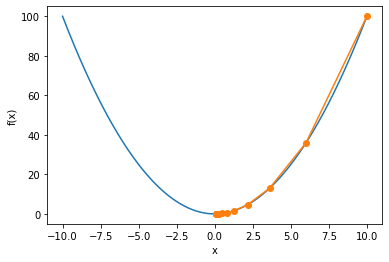

In [37]:
from matplotlib import pyplot as plt

def show_trace(res, f, n=None):
    if n is None:
        n = max(abs(min(res)), abs(max(res)))
    f_line = np.arange(-n, n, 0.01)
    plt.plot(f_line, [f(x) for x in f_line], '-')
    plt.plot(res, [f(x) for x in res], '-o')
    plt.xlabel('x')
    plt.ylabel('f(x)')

def f(x):
    return x**2  # Objective function

def gradf(x):
    return 2 * x  # Its derivative

def gd(eta):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * gradf(x)
        results.append(x)
    print('epoch 10, x:', results)
    return results

res = gd(0.2)  # learning rate is 0.2

show_trace(res, f)

epoch 10, x: [10, 9.0, 8.1, 7.289999999999999, 6.560999999999999, 5.9049, 5.31441, 4.782969, 4.3046720999999994, 3.8742048899999997, 3.4867844009999995]


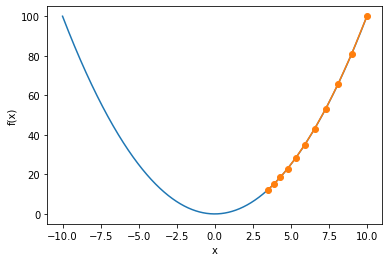

In [38]:
res = gd(0.05)  # learning rate is 0.2

show_trace(res, f) # 当我们设置学习率为 0.05 时，我们发现迭代变慢了

![img](Pics/x2.svg)

当我们设置学习率为 0.05 时，我们发现迭代变慢了
![img](Pics/x2small.svg)

当我们设置学习率为 1.1 时，我们发现迭代的函数值发散了

![img](Pics/x2big.svg)

可以发现，对于凸函数，梯度下降法我们需要较好的学习率才可以获得较好的迭代结果和迭代速度，其中学习率的设置可以参考这样一条规则，即学习率可以设置在 $[1/L, 2/L]$之间，当 $\eta = 1/L$时有最快的下降速度。其中 L 为 Hesse 矩阵中对应变量的特征值

我们了解了对于凸函数的情况，那么对于非凸函数表现如何呢？

#### 非凸函数上的表现
$$
f(x) = x\cos cx
$$

epoch 10, x: [10, -12.0, 14.400000000000002, -17.280000000000005, 20.736000000000008, -24.883200000000013, 29.859840000000023, -35.83180800000004, 42.998169600000054, -51.59780352000007, 61.917364224000096]


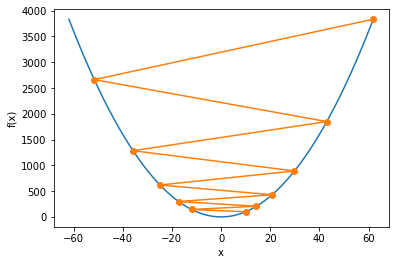

In [39]:
res = gd(1.1)  # learning rate is 1.1

show_trace(res, f)  # 当我们设置学习率为 1.1 时，我们发现迭代的函数值发散了

可以发现，对于凸函数，梯度下降法我们需要较好的学习率才可以获得较好的迭代结果和迭代速度，其中学习率的设置可以参考这样一条规则，即学习率可以设置在 $[1/L, 2/L]$之间，当 $\eta = 1/L$时有最快的下降速度。其中 L 为 Hesse 矩阵中对应变量的特征值

我们了解了对于凸函数的情况，那么对于非凸函数表现如何呢？

#### 非凸函数上的表现
$$
f(x) = x\cos cx
$$

epoch 10, x: [10, 9.057522203923062, 8.372623678087042, 7.943188877935551, 7.684418706381594, 7.527669734963812, 7.4314077778161245, 7.371583717010671, 7.334084373119446, 7.310442053717165, 7.2954792741140215]


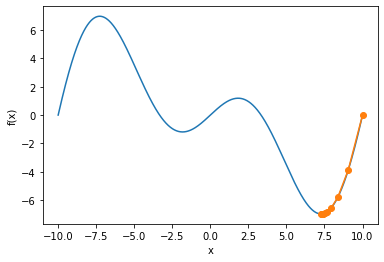

In [40]:
c = 0.15 * np.pi

def f(x):
    return x * np.cos(c * x)

def gradf(x):
    return np.cos(c * x) - c * x * np.sin(c * x)

res = gd(0.2)  # learning rate is 0.2

show_trace(res, f)


epoch 10, x: [10, 0.5752220392306207, -1.2065878533717997, -2.2795981343512657, -1.3434161011404435, -2.2067693526619374, -1.425789274899566, -2.1546340424025816, -1.483875897094285, -2.1143536052556744, -1.5281659276350823]


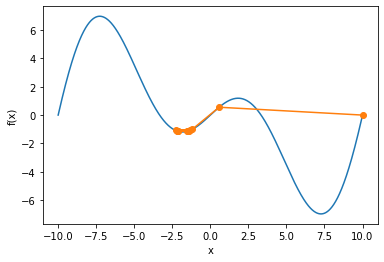

In [41]:
res = gd(2)  

show_trace(res, f)

可见其在学习率不合适时很容易收敛到局部极小点上


### 多维梯度下降


$$
\nabla f(\mathbf{x})=\left[\frac{\partial f(\mathbf{x})}{\partial x_{1}}, \frac{\partial f(\mathbf{x})}{\partial x_{2}}, \dots, \frac{\partial f(\mathbf{x})}{\partial x_{d}}\right]^{\top}
$$

$$
f(\mathbf{x}+\epsilon)=f(\mathbf{x})+\epsilon^{\top} \nabla f(\mathbf{x})+\mathcal{O}\left(\|\epsilon\|^{2}\right)
$$

$$
\mathbf{x} \leftarrow \mathbf{x}-\eta \nabla f(\mathbf{x})
$$

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def train_2d(trainer, steps=10):
    x1, x2 = -5, -2
    results = [(x1, x2)]
    for i in range(steps):
        x1, x2 = trainer(x1, x2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

def show_trace_2d(f, results):
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')


$$
f(x) = x_1^2 + 2x_2^2
$$


epoch 20, x1 -0.057646, x2 -0.000073


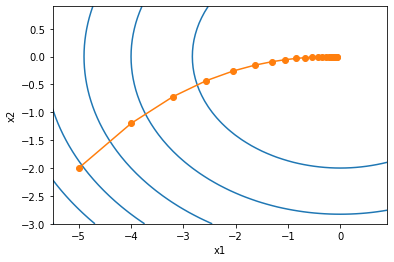

In [6]:
from Utils.utils import show_trace_2d
from Utils.utils import train_2d

eta = 0.1

def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2):  
    return (x1 - eta * 2 * x1, x2 - eta * 4 * x2)

show_trace_2d(f_2d, train_2d(gd_2d))

### 总结
- 引用于凸函数时，梯度下降法能较好地收敛到最优点，但是梯度下降法对于学习率的设置较敏感，可以根据 $ \eta \in [1/L,2/L]$ 来设置
- 梯度下降法对于非凸函数没有设置好学习率时很容易陷入在局部最优

# 自适应方法
之前我们发现设置学习率对基于梯度的优化方法影响很大，下面我们来看看一些希望自适应获得学习率的方法

### 牛顿法
牛顿法希望通过解析方式获得最优解，通过设置导数等于 0 求得解析解如下所示：

在 $x + \epsilon$ 处泰勒展开：

$$
f(\mathbf{x}+\epsilon)=f(\mathbf{x})+\epsilon^{\top} \nabla f(\mathbf{x})+\frac{1}{2} \epsilon^{\top} \nabla \nabla^{\top} f(\mathbf{x}) \epsilon+\mathcal{O}\left(\|\epsilon\|^{3}\right)
$$

最小值点处满足: $\nabla f(\mathbf{x})=0$, 即我们希望 $\nabla f(\mathbf{x} + \epsilon)=0$, 对上式关于 $\epsilon$ 求导，忽略高阶无穷小，有：

$$
\nabla f(\mathbf{x})+\boldsymbol{H}_{f} \boldsymbol{\epsilon}=0 \text { and hence } \epsilon=-\boldsymbol{H}_{f}^{-1} \nabla f(\mathbf{x})
$$

也许你发现通过解析解，我们可以只用迭代一步就找到全局最优。但是，泰勒展开仅当 $\epsilon$ 为极小量时成立，因此，牛顿法实际上并不能一步获得全局最优。

epoch 10, x: [10, 8.00018159147481, 6.0015227485135565, 4.011398229022884, 2.0825421834074804, 0.5257631592168077, 0.011785578458138546, 1.3641603793801416e-07, 1.852884572118782e-22, 0.0, 0.0]


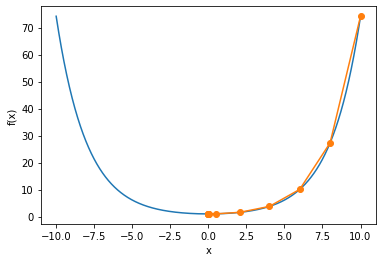

In [42]:
c = 0.5

def f(x):
    return np.cosh(c * x)  # Objective

def gradf(x):
    return c * np.sinh(c * x)  # Derivative

def hessf(x):
    return c**2 * np.cosh(c * x)  # Hessian

# Hide learning rate for now
def newton(eta=1):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * gradf(x) / hessf(x)
        results.append(x)
    print('epoch 10, x:', results)
    return results

show_trace(newton(), f)

epoch 10, x: [10, 5.000000000000003, 24.994879494194016, 27.783105997122323, 26.800099279328098, 26.834178613689314, 26.83413291332453, 26.83413291324767, 26.83413291324767, 26.83413291324767, 26.83413291324767]


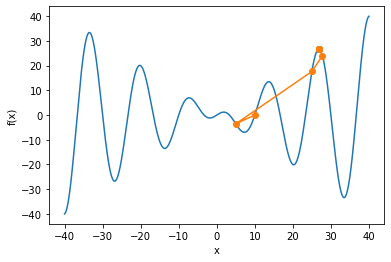

In [46]:

c = 0.15 * np.pi

def f(x):
    return x * np.cos(c * x)

def gradf(x):
    return np.cos(c * x) - c * x * np.sin(c * x)

def hessf(x):
    return - 2 * c * np.sin(c * x) - x * c**2 * np.cos(c * x)

show_trace(newton(), f, 40)

epoch 10, x: [10, 7.500000000000002, 7.3871648802624845, 7.329002380746055, 7.2993923724814165, 7.284441656516651, 7.27692802722112, 7.273161403549493, 7.27127560859203, 7.270332086428487, 7.269860168684531]


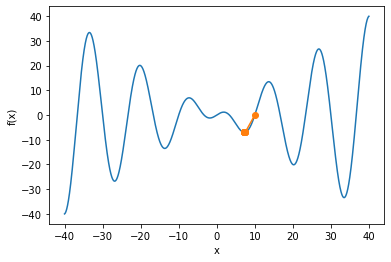

In [48]:
show_trace(newton(0.5), f, 40)

牛顿法遇到局部极小也会产生发散的问题，需要降低学习率来实现。
也许你发现牛顿法的初衷就是为了解决学习率设置的问题，但是到最后遇到非凸函数其还是不得不自行改变学习率，因此牛顿法其实主要还是适应于凸函数中不用调整学习率的情况。

### 总结
- 实施牛顿法需要计算 d\*d 的 Hesse 矩阵的逆（d 为自变量的个数），计算量非常大，但是对于最优解在局部领域内的情况可以一步到达最优解。
- 牛顿法对于凸函数可以省去设置学习率的过程，获得快速收敛的最优解。
- 牛顿法对于非凸函数依旧需要设置学习率来满足 Wolfe 条件，Wolfe 条件分别是最快下降条件和曲率条件，其保证了下降的速率。详细说明可以见[这里](https://www.jiqizhixin.com/graph/technologies/4761e6c4-223c-431f-9110-8b184068a885)


### 收敛性分析

只考虑在函数为凸函数, 且最小值点上 $f''(x^*) > 0$ 时的收敛速度：

令 $x_k$ 为第 $k$ 次迭代后 $x$ 的值， $e_{k}:=x_{k}-x^{*}$ 表示 $x_k$ 到最小值点 $x^{*}$ 的距离，由 $f'(x^{*}) = 0$:

$$
0=f^{\prime}\left(x_{k}-e_{k}\right)=f^{\prime}\left(x_{k}\right)-e_{k} f^{\prime \prime}\left(x_{k}\right)+\frac{1}{2} e_{k}^{2} f^{\prime \prime \prime}\left(\xi_{k}\right) \text{for some } \xi_{k} \in\left[x_{k}-e_{k}, x_{k}\right]
$$

两边除以 $f''(x_k)$, 有：

$$
e_{k}-f^{\prime}\left(x_{k}\right) / f^{\prime \prime}\left(x_{k}\right)=\frac{1}{2} e_{k}^{2} f^{\prime \prime \prime}\left(\xi_{k}\right) / f^{\prime \prime}\left(x_{k}\right)
$$

代入更新方程 $x_{k+1} = x_{k} - f^{\prime}\left(x_{k}\right) / f^{\prime \prime}\left(x_{k}\right)$, 得到：

$$
x_k - x^{*} - f^{\prime}\left(x_{k}\right) / f^{\prime \prime}\left(x_{k}\right) =\frac{1}{2} e_{k}^{2} f^{\prime \prime \prime}\left(\xi_{k}\right) / f^{\prime \prime}\left(x_{k}\right)
$$


$$
x_{k+1} - x^{*} = e_{k+1} = \frac{1}{2} e_{k}^{2} f^{\prime \prime \prime}\left(\xi_{k}\right) / f^{\prime \prime}\left(x_{k}\right)
$$

当 $\frac{1}{2} f^{\prime \prime \prime}\left(\xi_{k}\right) / f^{\prime \prime}\left(x_{k}\right) \leq c$ 时，有:

$$
e_{k+1} \leq c e_{k}^{2}
$$



结论： 牛顿法迭代一次可以使得 $x_k+1$ 到最小值点 $x^{*}$ 的距离 小于等于 $x_k$ 到最小值点 $x^{*}$ 的距离的平方的 c 倍

### 预处理 （Heissan阵辅助梯度下降）
牛顿法的另一个应用是，对于优化平面比较扁平的时候，我们可以使用 Heissan 矩阵中的对角线元素来规范前进的步长。


$$
\mathbf{x} \leftarrow \mathbf{x}-\eta \operatorname{diag}\left(H_{f}\right)^{-1} \nabla \mathbf{x}
$$



### 共轭梯度法
共轭梯度法是介于最速下降法与牛顿法之间的一个方法，它仅需一阶导数信息，但克服了最速下降法收敛慢的缺点，又避免了牛顿法需要存储和计算Hesse矩阵并求逆的缺点。 共轭梯度法的基本思想是把共轭性与最速下降法相结合，利用已知点处的梯度构造一组共轭方向，并沿这组方向进行搜索，求出目标函数的极小点。

共轭梯度的设计思想是通过构造共轭的梯度搜索方向，在仅需一阶导数信息的基础上，加快梯度下降法的迭代速度。其收敛速率能保证在 n 步之内，其中 n 为自变量的维度。

<img src="Pics/Conjugate_gradient_illustration.png" width="200" height="200" title="共轭梯度和最陡梯度对比" />


更多参考[Wikipedia](https://en.wikipedia.org/wiki/Conjugate_gradient_method)


# 随机梯度下降


## 随机梯度下降参数更新

对于有 $n$ 个样本对训练数据集，设 $f_i(x)$ 是第 $i$ 个样本的损失函数, 则目标函数为:

$$
f(\mathbf{x})=\frac{1}{n} \sum_{i=1}^{n} f_{i}(\mathbf{x})
$$

其梯度为:

$$
\nabla f(\mathbf{x})=\frac{1}{n} \sum_{i=1}^{n} \nabla f_{i}(\mathbf{x})
$$

使用该梯度的一次更新的时间复杂度为 $\mathcal{O}(n)$

随机梯度下降更新公式 $\mathcal{O}(1)$:

$$
\mathbf{x} \leftarrow \mathbf{x}-\eta \nabla f_{i}(\mathbf{x})
$$

且有：

$$
\mathbb{E}_{i} \nabla f_{i}(\mathbf{x})=\frac{1}{n} \sum_{i=1}^{n} \nabla f_{i}(\mathbf{x})=\nabla f(\mathbf{x})
$$


从上述推导可以看到，梯度下降方法的更新参数时间复杂度过高，因此我们在深度神经网络中采用随机梯度下降方法，其每次使用一个样本的梯度用来更新，这样可行的原因是通过把单个样本的梯度当成是对所有样本的梯度的平均估计

e.g.

$$
f(x_1, x_2) = x_1^2 + 2 x_2^2
$$


epoch 50, x1 -0.260906, x2 -0.114370


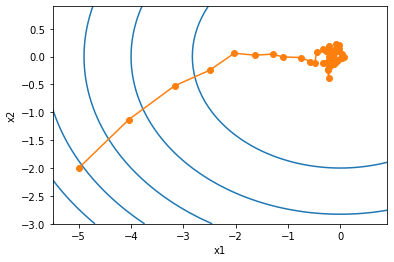

In [49]:
def f(x1, x2):
    return x1 ** 2 + 2 * x2 ** 2  # Objective

def gradf(x1, x2):
    return (2 * x1, 4 * x2)  # Gradient

def sgd(x1, x2):  # Simulate noisy gradient
    global lr  # Learning rate scheduler
    (g1, g2) = gradf(x1, x2)  # Compute gradient
    (g1, g2) = (g1 + np.random.normal(0.1), g2 + np.random.normal(0.1))
    eta_t = eta * lr()  # Learning rate at time t
    return (x1 - eta_t * g1, x2 - eta_t * g2)  # Update variables

eta = 0.1
lr = (lambda: 1)  # Constant learning rate
show_trace_2d(f, train_2d(sgd, steps=50))


可以看到，随机梯度下降法对于凸函数依旧可以找到最小点，但是其因为样本估计梯度中的噪声在最优值附近抖动，同时由于没有利用上并行计算，其速度较慢。

### 动态学习率
为了解决上述提到的由于样本估计梯度中的噪声在最优值附近抖动的问题，我们可以设置学习率策略（学习率先大后小），限制优化后期梯度中的噪声的影响。


$$
\begin{array}{ll}{\eta(t)=\eta_{i} \text { if } t_{i} \leq t \leq t_{i+1}} & {\text { piecewise constant }} \\ {\eta(t)=\eta_{0} \cdot e^{-\lambda t}} & {\text { exponential }} \\ {\eta(t)=\eta_{0} \cdot(\beta t+1)^{-\alpha}} & {\text { polynomial }}\end{array}
$$


epoch 1000, x1 -0.821215, x2 -0.120054


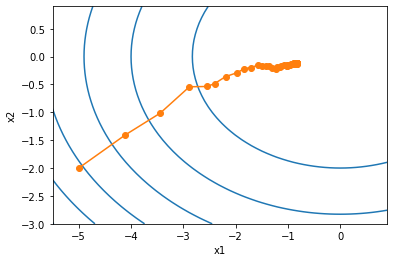

In [51]:
import math
def exponential():
    global ctr
    ctr += 1
    return math.exp(-0.1 * ctr)

ctr = 1
lr = exponential  # Set up learning rate
show_trace_2d(f, train_2d(sgd, steps=1000))

epoch 50, x1 -0.189153, x2 -0.136957


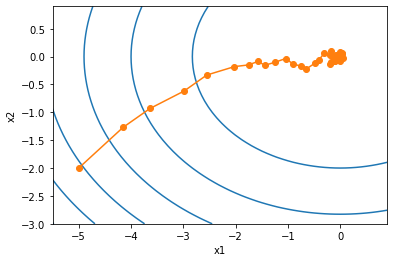

In [52]:
def polynomial():
    global ctr
    ctr += 1
    return (1 + 0.1 * ctr)**(-0.5)

ctr = 1
lr = polynomial  # Set up learning rate
show_trace_2d(f, train_2d(sgd, steps=50))

通过改变学习率变化策略，随机梯度下降法的后期抖动减少不少

# 小批量随机梯度下降

## [读取数据](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise)

In [ ]:
def get_data_ch7():  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    data = np.genfromtxt('/home/kesci/input/airfoil4755/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0) # 标准化
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
           torch.tensor(data[:1500, -1], dtype=torch.float32) # 前1500个样本(每个样本5个特征)

features, labels = get_data_ch7()
features.shape

In [ ]:
import pandas as pd
df = pd.read_csv('/home/kesci/input/airfoil4755/airfoil_self_noise.dat', delimiter='\t', header=None)
df.head(10)

### 简洁实现

In [9]:
# 本函数与原书不同的是这里第一个参数优化器函数而不是优化器的名字
# 例如: optimizer_fn=torch.optim.SGD, optimizer_hyperparams={"lr": 0.05}
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features, labels,
                    batch_size=10, num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            # 除以2是为了和train_ch7保持一致, 因为squared_loss中除了2
            l = loss(net(X).view(-1), y) / 2

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')

对比

In [ ]:
train_pytorch_ch7(optim.SGD, {"lr": 1}, features, labels, 1500) # 梯度下降

In [ ]:
train_pytorch_ch7(optim.SGD, {"lr": 0.005}, features, labels, 1) # 随机梯度下降

In [ ]:
train_pytorch_ch7(optim.SGD, {"lr": 0.05}, features, labels, 10) # 小批量梯度下降

### 总结
1. 随机梯度下降法：
    - 计算复杂度小：为了减小梯度下降法的计算复杂度设置，具有更新计算量小 $\mathcal{O}(1)$ 的特点
    - 计算效率低：没有利用上并行计算的能力，计算相比小批量梯度下降法更加慢
    - 优化后期抖动：由于单样本估计的梯度具有噪声，导致其容易在优化后期抖动，这一点可以通过动态设置学习率来解决

2. 小批量梯度下降：
    - 计算复杂度小：同$\mathcal{O}(1)$
    - 计算效率较高：增加 Batch Size 利用并行计算
    - 后期抖动较小

# 优化算法进阶
这一节我们通过介绍两种方法来解决优化平面 ill-conditioned 的问题，并就这个问题引出现有的很多优化算法。


## 病态问题
什么是病态问题呢？它描述的是优化平面由于输入不同维度的量纲以及幅度差异很大等原因，导致在某一些维度 $D_{slow}$ 损失函数值变化非常缓慢，而在另一些维度 $D_{fast}$ 损失函数值变化很快。从而导致基于梯度的算法在 $D_{fast}$ 维度不断震荡，从而难以优化到正确位置的情况。

### 病态问题的公式定义
Hessian 矩阵中的条件数:

$$
 cond_{H} = \frac{\lambda_{max}}{\lambda_{min}}
$$

$\lambda_{max}, \lambda_{min}$ 分别是 Hessian 矩阵中最大和最小的特征值. 条件数较大则为病态问题

让我们考虑一个输入和输出分别为二维向量$\boldsymbol{x} = [x_1, x_2]^\top$和标量的目标函数:


$$
 f(\boldsymbol{x})=0.1x_1^2+2x_2^2
$$



$$
 cond_{H} = \frac{4}{0.2} = 20 \quad \rightarrow \quad \text{条件数很大，因此是病态问题}
$$

下面实现基于这个目标函数的梯度下降，并演示使用学习率为$0.4$时自变量的迭代轨迹。

epoch 20, x1 -0.943467, x2 -0.000073


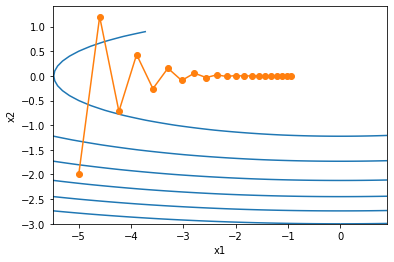

In [2]:
%matplotlib inline
from Utils.utils import show_trace_2d, train_2d

eta = 0.4

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2)

show_trace_2d(f_2d, train_2d(gd_2d))

可以看到，同一位置上，因为目标函数在竖直方向（$x_2$轴方向）比在水平方向（$x_1$轴方向）的斜率的绝对值更大。因此，给定学习率，梯度下降迭代自变量时会使自变量在竖直方向比在水平方向移动幅度更大。那么，我们需要一个较小的学习率从而避免自变量在竖直方向上越过目标函数最优解。然而，这会造成自变量在水平方向上朝最优解移动变慢。

下面我们试着将学习率调得稍大一点，此时自变量在竖直方向不断越过最优解并逐渐发散。

epoch 20, x1 -0.387814, x2 -1673.365109


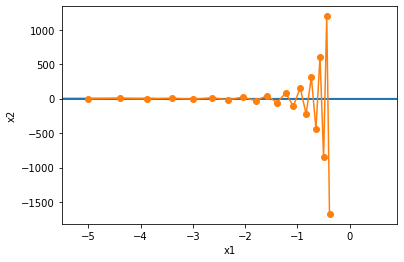

In [3]:
eta = 0.6  ## 注意到在 x2 维度的 L=4，因此 2/L = 0.5，大于0.5将会引起发散 
show_trace_2d(f_2d, train_2d(gd_2d))

### 病态问题的解决方法

我们可以采用多种方法来解决这类问题：
- 输入和中间变量归一化：归一化有助于将不同维度变量的量纲统一，可以使得优化平面更加规整
- 平均历史梯度：使用基于 momentum 的梯度下降算法，使得 $D_{fast}$ 方向的优化方向为历史平均值，从而减少震荡的结果。这样可以使用更大的学习率也不用担心优化结果发散。在 Adam, RMSProp, SGD momentum 均有应用。
- Preconditioning：在二阶优化中，我们使用Hessian matrix的逆矩阵(或者pseudo inverse)来左乘梯度向量 $i.e. \Delta_{x} = H^{-1}\mathbf{g}$，这样的做法称为precondition，相当于将 $H$ 映射为一个单位矩阵，拥有分布均匀的Spectrum，也即我们去优化的等价标函数的Hessian matrix为良好的identity matrix。Adam, RMSProp, AdaGrad, Adelta, KFC, Natural gradient 等优化算法就借鉴了 preconditioning 的思想

## Momentum
这一节我们介绍基于动量的方法来解决优化平面 ill-conditioned 的问题


## Momentum Algorithm

动量法的提出是为了解决梯度下降的上述问题。设时间步 $t$ 的自变量为 $\boldsymbol{x}_t$，学习率为 $\eta_t$。
在时间步 $t=0$，动量法创建速度变量 $\boldsymbol{m}_0$，并将其元素初始化成 0。在时间步 $t>0$，动量法对每次迭代的步骤做如下修改：


$$
\begin{aligned}
\boldsymbol{m}_t &\leftarrow \beta \boldsymbol{m}_{t-1} + \eta_t \boldsymbol{g}_t, \\
\boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{m}_t,
\end{aligned}
$$

另一种表达（将梯度使用滑动平均之后，再使用调整过的学习率进行更新）:

$$
\begin{aligned}
\boldsymbol{m}_t &\leftarrow \beta \boldsymbol{m}_{t-1} + (1-\beta) \boldsymbol{g}_t, \\
\boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \alpha_t \boldsymbol{m}_t,  \\
\boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \frac{\eta_t * \beta}{1-\beta} \boldsymbol{m}_{t-1} - \eta_t * \boldsymbol{g}_t,
\end{aligned}
$$

$$
\alpha_t = \frac{\eta_t}{1-\beta}
$$

其中，动量超参数 $\beta$满足 $0 \leq \beta < 1$。当 $\beta=0$ 时，动量法等价于小批量随机梯度下降。

在解释动量法的数学原理前，让我们先从实验中观察梯度下降在使用动量法后的迭代轨迹。

epoch 20, x1 -0.062843, x2 0.001202


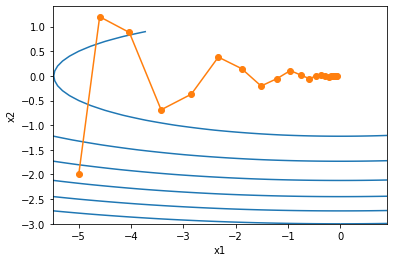

In [6]:
import matplotlib.pyplot as plt
import numpy as np


def train_2d_momentum(trainer, steps=20):
    x1, x2 = -5, -2
    v1, v2 = 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        x1, x2, v1, v2 = trainer(x1, x2, v1, v2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results


def show_trace_2d(f, results):
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + eta * 0.2 * x1
    v2 = beta * v2 + eta * 4 * x2
    return x1 - v1, x2 - v2, v1, v2


eta, beta = 0.4, 0.5

show_trace_2d(f_2d, train_2d_momentum(momentum_2d))

可以看到使用较小的学习率 $\eta=0.4$ 和动量超参数 $\beta=0.5$ 时，动量法在竖直方向上的移动更加平滑，且在水平方向上更快逼近最优解。下面使用较大的学习率 $\eta=0.6$，此时自变量也不再发散。

epoch 20, x1 0.007188, x2 0.002553


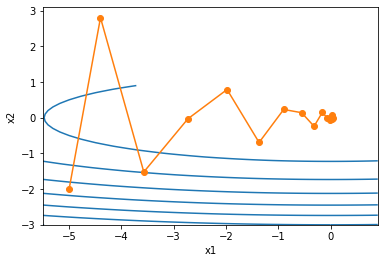

In [5]:
eta = 0.6
show_trace_2d(f_2d, train_2d_momentum(momentum_2d))

### Exponential Moving Average

为了从数学上理解动量法，让我们先解释一下指数加权移动平均（exponential moving average）。给定超参数 $0 \leq \beta < 1$，当前时间步 $t$ 的变量 $y_t$ 是上一时间步 $t-1$ 的变量 $y_{t-1}$ 和当前时间步另一变量 $x_t$ 的线性组合：

$$
y_t = \beta y_{t-1} + (1-\beta) x_t.
$$

我们可以对 $y_t$ 展开：

$$
\begin{aligned}
y_t  &= (1-\beta) x_t + \beta y_{t-1}\\
         &= (1-\beta)x_t + (1-\beta) \cdot \beta x_{t-1} + \beta^2y_{t-2}\\
         &= (1-\beta)x_t + (1-\beta) \cdot \beta x_{t-1} + (1-\beta) \cdot \beta^2x_{t-2} + \beta^3y_{t-3}\\
         &= (1-\beta) \sum_{i=0}^{t} \beta^{i}x_{t-i}
\end{aligned}
$$

$$
(1-\beta)\sum_{i=0}^{t} \beta^{i} = \frac{1-\beta^{t}}{1-\beta} (1-\beta) = (1-\beta^{t})
$$


### 补充结论：指数加权平均约等于 $\frac{1}{1-\beta}$ 个历史结果的指数加权平均
例如 $\beta = 0.95$ 时，约等于过去 $\frac{1}{1-\beta} = \frac{1}{1-0.95} = 20$ 个结果的指数加权平均 

令 $n = \frac{1}{1-\beta}$，那么 $\left(1-1/n\right)^n = \beta^{\frac{1}{1-\beta}}$。因为

$$
 \lim_{n \rightarrow \infty}  \left(1-\frac{1}{n}\right)^n = \exp(-1) \approx 0.3679,
$$

所以当 $\beta \rightarrow 1$时，$\beta^{1/(1-\beta)}=\exp(-1)$，如 $0.95^{20} \approx \exp(-1)$。那么对于第 20 项，其加权系数就等于 $(1-\beta)*\exp(-1) = 0.01839$ 是一个很小的数了。

因此，我们可以在近似中忽略所有含 $\beta^{1/(1-\beta)}$ 和比 $\beta^{1/(1-\beta)}$ 更高阶的系数的项。例如，当 $\beta=0.95$ 时，

$$
y_t \approx 0.05 \sum_{i=0}^{19} 0.95^i x_{t-i}.
$$

因此，在实际中，我们常常将 $y_t$ 看作是对最近 $1/(1-\beta)$ 个时间步的 $x_t$ 值的加权平均。例如，当 $\gamma = 0.95$ 时，$y_t$ 可以被看作对最近20个时间步的 $x_t$ 值的加权平均；当 $\beta = 0.9$ 时，$y_t$ 可以看作是对最近10个时间步的 $x_t$ 值的加权平均。而且，离当前时间步 $t$ 越近的 $x_t$ 值获得的权重越大（越接近1）。

### 由指数加权移动平均理解动量法

现在，我们对动量法的速度变量做变形：

$$
\boldsymbol{m}_t \leftarrow \frac{\eta_t * \beta}{1 - \beta}\boldsymbol{m}_{t-1} + (1 - \beta) \left(\frac{\eta_t}{1 - \beta} \boldsymbol{g}_t\right).
$$

Another version:

$$
\boldsymbol{m}_t \leftarrow \beta \boldsymbol{m}_{t-1} + (1 - \beta) \boldsymbol{g}_t.
$$


$$
\begin{aligned}
\boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \alpha_t \boldsymbol{m}_t,
\end{aligned}
$$


$$
\alpha_t = \frac{\eta_t}{1-\beta}
$$


由指数加权移动平均的形式可得，速度变量 $\boldsymbol{v}_t$ 实际上对序列 $\{\frac{\eta_{t-i}}{1 - \beta} \boldsymbol{g}_{t-i}: i=0,\ldots,1/(1-\beta)-1\}$ 做了指数加权移动平均。换句话说，相比于小批量随机梯度下降，动量法在每个时间步的自变量更新量近似于将前者对应的最近 $1/(1-\beta)$ 个时间步的更新量做了指数加权移动平均后再除以 $1-\beta$(更新速率放大了 $1/(1-\beta)$ 倍)。

所以，在动量法中，自变量在各个方向上的移动幅度不仅取决当前梯度，还取决于过去的各个梯度在各个方向上是否一致。在本节之前示例的优化问题中，所有梯度在水平方向上为正（向右），而在竖直方向上时正（向上）时负（向下）。这样，我们就可以使用较大的学习率，从而使自变量向最优解更快移动。


## Implement

相对于小批量随机梯度下降，动量法需要对每一个自变量维护一个同它一样形状的速度变量，且超参数里多了动量超参数。实现中，我们将速度变量用更广义的状态变量`states`表示。

In [ ]:
def get_data_ch7():
    data = np.genfromtxt('/home/kesci/input/airfoil4755/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
        torch.tensor(data[:1500, -1], dtype=torch.float32)

features, labels = get_data_ch7()

def init_momentum_states():
    v_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    v_b = torch.zeros(1, dtype=torch.float32)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        v.data = hyperparams['momentum'] * v.data + hyperparams['lr'] * p.grad.data
        p.data -= v.data

我们先将动量超参数`momentum`设0.5

In [ ]:
train_pytorch_ch7(torch.optim.SGD, {'lr': 0.02, 'momentum': 0.5},
                    features, labels)

将动量超参数`momentum`增大到0.9

In [ ]:
train_pytorch_ch7(torch.optim.SGD, {'lr': 0.02, 'momentum': 0.9},
                    features, labels)

可见目标函数值在后期迭代过程中的变化不够平滑。直觉上，10倍小批量梯度比2倍小批量梯度大了5倍，我们可以试着将学习率减小到原来的1/5。此时目标函数值在下降了一段时间后变化更加平滑。

In [ ]:
train_pytorch_ch7(torch.optim.SGD, {'lr': 0.004, 'momentum': 0.9},
                    features, labels)

# 11.7 AdaGrad 累加梯度平方来归一化梯度的算法

在之前介绍过的优化算法中，目标函数自变量的每一个元素在相同时间步都使用同一个学习率来自我迭代。举个例子，假设目标函数为$f$，自变量为一个二维向量$[x_1, x_2]^\top$，该向量中每一个元素在迭代时都使用相同的学习率。例如，在学习率为$\eta$的梯度下降中，元素$x_1$和$x_2$都使用相同的学习率$\eta$来自我迭代：


$$
x_1 \leftarrow x_1 - \eta \frac{\partial{f}}{\partial{x_1}}, \quad
x_2 \leftarrow x_2 - \eta \frac{\partial{f}}{\partial{x_2}}.
$$


在[“动量法”](./momentum.ipynb)一节里我们看到当$x_1$和$x_2$的梯度值有较大差别时，需要选择足够小的学习率使得自变量在梯度值较大的维度上不发散。但这样会导致自变量在梯度值较小的维度上迭代过慢。动量法依赖指数加权移动平均使得自变量的更新方向更加一致，从而降低发散的可能。本节我们介绍AdaGrad算法，它根据自变量在每个维度的梯度值的大小来调整各个维度上的学习率，从而避免统一的学习率难以适应所有维度的问题 [1]。



## Algorithm

AdaGrad算法会使用一个小批量随机梯度$\boldsymbol{g}_t$按元素平方的累加变量$\boldsymbol{s}_t$。在时间步0，AdaGrad将$\boldsymbol{s}_0$中每个元素初始化为0。在时间步$t$，首先将小批量随机梯度$\boldsymbol{g}_t$按元素平方后累加到变量$\boldsymbol{s}_t$：


$$
\boldsymbol{s}_t \leftarrow \boldsymbol{s}_{t-1} + \boldsymbol{g}_t \odot \boldsymbol{g}_t,
$$


其中$\odot$是按元素相乘。接着，我们将目标函数自变量中每个元素的学习率通过按元素运算重新调整一下：


$$
\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t,
$$


其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-6}$。这里开方、除法和乘法的运算都是按元素运算的。这些按元素运算使得目标函数自变量中每个元素都分别拥有自己的学习率。

## Feature

需要强调的是，小批量随机梯度按元素平方的累加变量$\boldsymbol{s}_t$出现在学习率的分母项中。因此，如果目标函数有关自变量中某个元素的偏导数一直都较大，那么该元素的学习率将下降较快；反之，如果目标函数有关自变量中某个元素的偏导数一直都较小，那么该元素的学习率将下降较慢。然而，由于$\boldsymbol{s}_t$一直在累加按元素平方的梯度，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。所以，当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。

## AdaGrad 总结
- 伪归一化操作促使大梯度的方向学习率较小，小梯度的方向学习率衰减较慢，促进了梯度更新的平衡
- 由于用于伪归一化的数值是梯度平方累加之后开根号，其会促使学习率不断衰减，如果完全衰减之前找不到好的解就会停滞不前

下面我们仍然以目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$为例观察AdaGrad算法对自变量的迭代轨迹。我们实现AdaGrad算法并使用和上一节实验中相同的学习率0.4。可以看到，自变量的迭代轨迹较平滑。但由于$\boldsymbol{s}_t$的累加效果使学习率不断衰减，自变量在迭代后期的移动幅度较小。

epoch 20, x1 -2.382563, x2 -0.158591


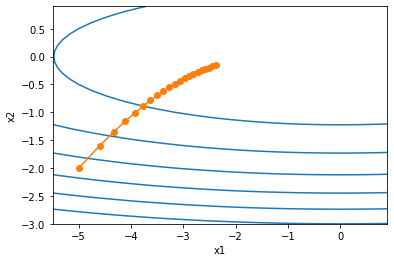

In [13]:
%matplotlib inline
import math
import torch
import sys

def adagrad_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6  # 前两项为自变量梯度
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
show_trace_2d(f_2d, train_2d_momentum(adagrad_2d))

下面将学习率增大到2。可以看到自变量更为迅速地逼近了最优解。

epoch 20, x1 -0.002295, x2 -0.000000


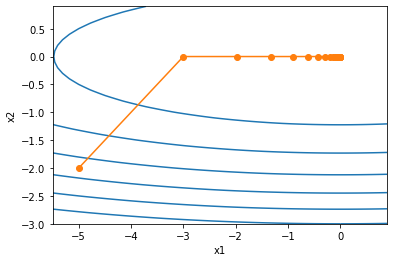

In [14]:
eta = 2
show_trace_2d(f_2d, train_2d_momentum(adagrad_2d))

## Implement

同动量法一样，AdaGrad算法需要对每个自变量维护同它一样形状的状态变量。我们根据AdaGrad算法中的公式实现该算法。

In [ ]:
def get_data_ch7():
    data = np.genfromtxt('/home/kesci/input/airfoil4755/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
        torch.tensor(data[:1500, -1], dtype=torch.float32)

features, labels = get_data_ch7()

def init_adagrad_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        s.data += (p.grad.data**2)
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s + eps)

使用更大的学习率来训练模型。

In [ ]:
train_pytorch_ch7(torch.optim.Adagrad, {'lr': 0.1}, features, labels)

# 11.8 RMSProp

我们在[“AdaGrad算法”](adagrad.ipynb)一节中提到，因为调整学习率时分母上的变量$\boldsymbol{s}_t$一直在累加按元素平方的小批量随机梯度，所以目标函数自变量每个元素的学习率在迭代过程中一直在降低（或不变）。因此，当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。为了解决这一问题，RMSProp算法对AdaGrad算法做了修改。该算法源自Coursera上的一门课程，即“机器学习的神经网络”。

## Algorithm

我们在[“动量法”](momentum.ipynb)一节里介绍过指数加权移动平均。不同于AdaGrad算法里状态变量$\boldsymbol{s}_t$是截至时间步$t$所有小批量随机梯度$\boldsymbol{g}_t$按元素平方和，RMSProp算法将这些梯度按元素平方做指数加权移动平均。具体来说，给定超参数$\beta$计算


$$
\boldsymbol{v}_t \leftarrow \beta \boldsymbol{v}_{t-1} + (1 - \beta) \boldsymbol{g}_t \odot \boldsymbol{g}_t.
$$


和AdaGrad算法一样，RMSProp算法将目标函数自变量中每个元素的学习率通过按元素运算重新调整，然后更新自变量


$$
\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\alpha}{\sqrt{\boldsymbol{v}_t + \epsilon}} \odot \boldsymbol{g}_t,
$$


其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-6}$。因为RMSProp算法的状态变量$\boldsymbol{s}_t$是对平方项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$的指数加权移动平均，所以可以看作是最近$1/(1-\beta)$个时间步的小批量随机梯度平方项的加权平均。如此一来，自变量每个元素的学习率在迭代过程中就不再一直降低（或不变）。

照例，让我们先观察RMSProp算法对目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$中自变量的迭代轨迹。回忆在[“AdaGrad算法”](adagrad.ipynb)一节使用的学习率为0.4的AdaGrad算法，自变量在迭代后期的移动幅度较小。但在同样的学习率下，RMSProp算法可以更快逼近最优解。

epoch 20, x1 -0.010599, x2 0.000000


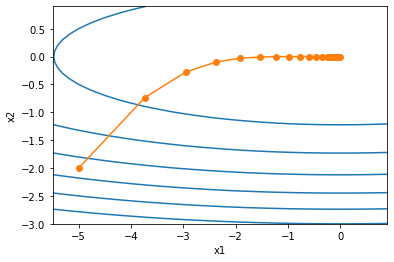

In [16]:
%matplotlib inline
import math

def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = beta * s1 + (1 - beta) * g1 ** 2
    s2 = beta * s2 + (1 - beta) * g2 ** 2
    x1 -= alpha / math.sqrt(s1 + eps) * g1
    x2 -= alpha / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

alpha, beta = 0.4, 0.9
show_trace_2d(f_2d, train_2d_momentum(rmsprop_2d))

## Implement

接下来按照RMSProp算法中的公式实现该算法。

In [ ]:
def get_data_ch7():
    data = np.genfromtxt('/home/kesci/input/airfoil4755/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
        torch.tensor(data[:1500, -1], dtype=torch.float32)

features, labels = get_data_ch7()

def init_rmsprop_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['beta'], 1e-6
    for p, s in zip(params, states):
        s.data = gamma * s.data + (1 - gamma) * (p.grad.data)**2
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s + eps)

我们将初始学习率设为0.01，并将超参数$\gamma$设为0.9。此时，变量$\boldsymbol{s}_t$可看作是最近$1/(1-0.9) = 10$个时间步的平方项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$的加权平均。

## Pytorch Class

通过名称为“rmsprop”的`Trainer`实例，我们便可使用Gluon提供的RMSProp算法来训练模型。注意，超参数$\gamma$通过`gamma1`指定。

In [17]:
train_pytorch_ch7(torch.optim.RMSprop, {'lr': 0.01, 'alpha': 0.9},
                    features, labels)

NameError: name 'features' is not defined

## RMSprop 总结
通过将 AdaGrad 的伪归一化操作中的梯度平方的累加值替换为梯度的指数滑动平均值，其促使学习率不那么快地衰减，归一化梯度的同时，保持了优化的活力

# 11.9 AdaDelta

除了RMSProp算法以外，另一个常用优化算法AdaDelta算法也针对AdaGrad算法在迭代后期可能较难找到有用解的问题做了改进 [1]。有意思的是，AdaDelta算法没有学习率这一超参数。

## Algorithm

AdaDelta算法也像RMSProp算法一样，使用了小批量随机梯度$\boldsymbol{g}_t$按元素平方的指数加权移动平均变量$\boldsymbol{s}_t$。在时间步0，它的所有元素被初始化为0。给定超参数$0 \leq \rho 0$，同RMSProp算法一样计算


$$
\boldsymbol{s}_t \leftarrow \rho \boldsymbol{s}_{t-1} + (1 - \rho) \boldsymbol{g}_t \odot \boldsymbol{g}_t.
$$


与RMSProp算法不同的是，AdaDelta算法还维护一个额外的状态变量$\Delta\boldsymbol{x}_t$，其元素同样在时间步0时被初始化为0。我们使用$\Delta\boldsymbol{x}_{t-1}$来计算自变量的变化量：


$$
 \boldsymbol{g}_t' \leftarrow \sqrt{\frac{\Delta\boldsymbol{x}_{t-1} + \epsilon}{\boldsymbol{s}_t + \epsilon}}   \odot \boldsymbol{g}_t,
$$


其中$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-5}$。接着更新自变量：


$$
\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}'_t.
$$


最后，我们使用$\Delta\boldsymbol{x}_t$来记录自变量变化量$\boldsymbol{g}'_t$按元素平方的指数加权移动平均：


$$
\Delta\boldsymbol{x}_t \leftarrow \rho \Delta\boldsymbol{x}_{t-1} + (1 - \rho) \boldsymbol{g}'_t \odot \boldsymbol{g}'_t.
$$


可以看到，如不考虑$\epsilon$的影响，AdaDelta算法与RMSProp算法的不同之处在于使用 $\sqrt{\Delta\boldsymbol{x}_{t-1}}$ (也就是规范后的自变量额变化量的指数滑动平均)来替代超参数$\eta$。


## Implement

AdaDelta算法需要对每个自变量维护两个状态变量，即$\boldsymbol{s}_t$和$\Delta\boldsymbol{x}_t$。我们按AdaDelta算法中的公式实现该算法。

In [19]:
def init_adadelta_states():
    s_w, s_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    delta_w, delta_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        s[:] = rho * s + (1 - rho) * (p.grad.data**2)
        g =  p.grad.data * torch.sqrt((delta + eps) / (s + eps))
        p.data -= g
        delta[:] = rho * delta + (1 - rho) * g * g


## Pytorch Class

通过名称为“adadelta”的`Trainer`实例，我们便可使用pytorch提供的AdaDelta算法。它的超参数可以通过`rho`来指定。

In [ ]:
train_pytorch_ch7(torch.optim.Adadelta, {'rho': 0.9}, features, labels)

# 11.10 Adam

Adam算法在RMSProp算法基础上对小批量随机梯度也做了指数加权移动平均 [1]。下面我们来介绍这个算法。

## Algorithm

Adam算法使用了动量变量$\boldsymbol{m}_t$和RMSProp算法中小批量随机梯度按元素平方的指数加权移动平均变量$\boldsymbol{v}_t$，并在时间步0将它们中每个元素初始化为0。给定超参数$0 \leq \beta_1 < 1$（算法作者建议设为0.9），时间步$t$的动量变量$\boldsymbol{m}_t$即小批量随机梯度$\boldsymbol{g}_t$的指数加权移动平均：


$$
\boldsymbol{m}_t \leftarrow \beta_1 \boldsymbol{m}_{t-1} + (1 - \beta_1) \boldsymbol{g}_t.
$$


和RMSProp算法中一样，给定超参数$0 \leq \beta_2 < 1$（算法作者建议设为0.999），
将小批量随机梯度按元素平方后的项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$做指数加权移动平均得到$\boldsymbol{v}_t$：


$$
\boldsymbol{v}_t \leftarrow \beta_2 \boldsymbol{v}_{t-1} + (1 - \beta_2) \boldsymbol{g}_t \odot \boldsymbol{g}_t.
$$


由于我们将$\boldsymbol{m}_0$和$\boldsymbol{s}_0$中的元素都初始化为0，
在时间步$t$我们得到$\boldsymbol{m}_t =  (1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} \boldsymbol{g}_i$。将过去各时间步小批量随机梯度的权值相加，得到 $(1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} = 1 - \beta_1^t$。需要注意的是，当$t$较小时，过去各时间步小批量随机梯度权值之和会较小。例如，当$\beta_1 = 0.9$时，$\boldsymbol{m}_1 = 0.1\boldsymbol{g}_1$。为了消除这样的影响，对于任意时间步$t$，我们可以将$\boldsymbol{m}_t$再除以$1 - \beta_1^t$，从而使过去各时间步小批量随机梯度权值之和为1。这也叫作偏差修正。在Adam算法中，我们对变量$\boldsymbol{m}_t$和$\boldsymbol{v}_t$均作偏差修正：


$$
\hat{\boldsymbol{m}}_t \leftarrow \frac{\boldsymbol{m}_t}{1 - \beta_1^t},
$$



$$
\hat{\boldsymbol{v}}_t \leftarrow \frac{\boldsymbol{v}_t}{1 - \beta_2^t}.
$$



接下来，Adam算法使用以上偏差修正后的变量$\hat{\boldsymbol{m}}_t$和$\hat{\boldsymbol{m}}_t$，将模型参数中每个元素的学习率通过按元素运算重新调整：


$$
\boldsymbol{g}_t' \leftarrow \frac{\eta \hat{\boldsymbol{m}}_t}{\sqrt{\hat{\boldsymbol{v}}_t} + \epsilon},
$$


其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-8}$。和AdaGrad算法、RMSProp算法以及AdaDelta算法一样，目标函数自变量中每个元素都分别拥有自己的学习率。最后，使用$\boldsymbol{g}_t'$迭代自变量：


$$
\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}_t'.
$$

### Adam 算法总结
通过结合 momentum 和 pre-conditioning 两种方法实现对自变量的更新，保证了梯度的规范化来解决了 ill-condition 的问题，同时采用了偏差矫正，保证momentum 历史加权之和为 1。



## Implement

我们按照Adam算法中的公式实现该算法。其中时间步$t$通过`hyperparams`参数传入`adam`函数。

In [ ]:
%matplotlib inline
import torch

def get_data_ch7():
    data = np.genfromtxt('/home/kesci/input/airfoil4755/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
        torch.tensor(data[:1500, -1], dtype=torch.float32)

features, labels = get_data_ch7()

def init_adam_states():
    v_w, v_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    s_w, s_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        v[:] = beta1 * v + (1 - beta1) * p.grad.data
        s[:] = beta2 * s + (1 - beta2) * p.grad.data**2
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p.data -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
    hyperparams['t'] += 1

In [ ]:
train_pytorch_ch7(torch.optim.Adam, {'lr': 0.01}, features, labels)